In [1]:
import matplotlib.pyplot as plt
plt.style.use("nature_neurosci.mplstyle")


# Define colors
colors = {
    "Single": "#333333",
    "Left": "#246EB9",
    "Right": "#8B1E3F",
    "Ipsilateral": "#1B9E77",
    "Contralateral": "#D95F02",
    "Within": "#2B4162",
    "Across": "#E89D0B",
    'SerialBiasWeak': '#254441',
    'SerialBias': '#43AA8B',\
    'ReactivationWeak': '#7A8A99',
    'Reactivation': '#12719E'
}

from matplotlib.colors import LinearSegmentedColormap
left_right_cmap = LinearSegmentedColormap.from_list("LeftRight",\
                                                     [colors['Left'], "white", colors['Right']])
ipsi_contra_cmap = LinearSegmentedColormap.from_list("IpsiContra",\
                                                     [colors['Ipsilateral'], "white", colors['Contralateral']])
within_cmap = LinearSegmentedColormap.from_list("Within",\
                                                     ["white", colors['Within']])
across_cmap = LinearSegmentedColormap.from_list("Across",\
                                                     ["white", colors['Across']])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cmath import phase
from scipy.stats import circmean, sem
import random
from ast import literal_eval
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib

def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(np.array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return np.nan

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return np.array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

def sig_bar(sigs,axis,y,ax,color):
	w=np.diff(axis)[0]
	for s in sigs:
		beg =axis[s]-w/2
		end = axis[s]+w/2
		ax.fill_between([beg,end],[y[0],y[0]],[y[1],y[1]],color=color)
        
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

def normgauss(xxx,sigma):
    gauss = (1/(sigma*np.sqrt(2*np.pi)) *np.exp(-(xxx-0)**2 / (2*sigma**2)))
    return gauss/gauss.max()

def normgrad(xxx):
    return np.gradient(xxx)/np.gradient(xxx).max()

def dog1(sigma,x):
    xxx     = np.arange(-2*np.pi, 2*np.pi, .0001) 
    dog_1st = normgrad(normgauss(xxx,sigma))
    return np.array(list(map(lambda x: dog_1st[find_nearest(xxx,x)], x)))

def mov_avg(rel_loc, err, w1, w2, folded):  
    m_err=[]
    std_err=[]
    count=[]
    cis=[]
    x = np.arange(-np.pi,np.pi,w1)
    if folded:
        err = np.array([np.sign(rel_loc[i])*err[i] if np.sign(rel_loc[i])!=0 else err[i] for i in range(len(err))])
        rel_loc = np.abs(rel_loc)
        x = np.arange(0,np.pi,w1)
    for i,t in enumerate(x):
        idx=abs(circdist(rel_loc,t)) <= w2/2
        m_err.append(np.mean(err[idx]))
        std_err.append(sem(err[idx]))
           
    return (x), np.array(m_err),np.array(std_err)

def decode(angles, firing_rate, N_e):
    R = []
    R = np.sum(np.dot(firing_rate,np.exp(1j*angles)))/N_e
    angle = np.angle(R)
    #if angle < 0:
    #    angle +=2*np.pi
    return angle, np.abs(R) 

---

In [3]:
filename = './Results/Figure6/TwoAreaMultiitem_002_ipsi80'
df_models = pd.read_csv(filename+'.csv')

try:
    df_models['response1bump_area1'] = [literal_eval(df_models['response1bump_area1'][i]) for i in df_models.index]
    df_models['response1bump_area2'] = [literal_eval(df_models['response1bump_area2'][i]) for i in df_models.index]
    df_models['FR_area1'] = [literal_eval(df_models['FR_area1'][i]) for i in df_models.index]
    df_models['FR_area2'] = [literal_eval(df_models['FR_area2'][i]) for i in df_models.index]
    df_models['FR_center1_area1'] = [literal_eval(df_models['FR_center1_area1'][i]) for i in df_models.index]
    df_models['FR_center1_area2'] = [literal_eval(df_models['FR_center1_area2'][i]) for i in df_models.index]
    df_models['bump_average_area1'] = [literal_eval(df_models['bump_average_area1'][i]) for i in df_models.index]
    df_models['bump_average_area2'] = [literal_eval(df_models['bump_average_area2'][i]) for i in df_models.index]
    df_models['time_average'] = [literal_eval(df_models['time_average'][i]) for i in df_models.index]
except KeyError:
    # first time running need to rename some columns
    cols = ['nan1','stim1A_location', 'stim1B_location',\
            'HEMI_A', 'HEMI_B', 'HEMI_DIFF',\
                'FR_area1', 'FR_area2',\
                'FR_center1_area1', 'FR_center1_area2',\
            'response1bump_area1', 'response1_area1', 'responsestrength1_area1',\
             'response1bump_area2', 'response1_area2', 'responsestrength1_area2',\
                'delay1',\
                'stim_start',\
                'stim_duration',\
                'bump_average_area1', 'bump_average_area2',\
                'time_average',\
                'window', 'steps', 'across_factor']
    df_models = df_models.rename(columns={df_models.columns[i]: cols[i] for i in range(len(cols))})

    df_models.drop(['nan1'],axis=1, inplace=True)
    df_models.to_csv(filename+'.csv')
    
    df_models['FR_area1'] = [literal_eval(df_models['FR_area1'][i]) for i in df_models.index]
    df_models['FR_area2'] = [literal_eval(df_models['FR_area2'][i]) for i in df_models.index]
    df_models['response1bump_area1'] = [literal_eval(df_models['response1bump_area1'][i]) for i in df_models.index]
    df_models['response1bump_area2'] = [literal_eval(df_models['response1bump_area2'][i]) for i in df_models.index]
    df_models['FR_center1_area1'] = [literal_eval(df_models['FR_center1_area1'][i]) for i in df_models.index]
    df_models['FR_center1_area2'] = [literal_eval(df_models['FR_center1_area2'][i]) for i in df_models.index]
    df_models['bump_average_area1'] = [literal_eval(df_models['bump_average_area1'][i]) for i in df_models.index]
    df_models['bump_average_area2'] = [literal_eval(df_models['bump_average_area2'][i]) for i in df_models.index]
    df_models['time_average'] = [literal_eval(df_models['time_average'][i]) for i in df_models.index]

    
df_models['stimA_location_rad'] = np.deg2rad(df_models.stim1A_location) -\
                        (np.deg2rad(df_models.stim1A_location)>np.pi).astype(int)*2*np.pi
df_models['stimB_location_rad'] = np.deg2rad(df_models.stim1B_location) -\
                        (np.deg2rad(df_models.stim1B_location)>np.pi).astype(int)*2*np.pi

# response as average from both sides
df_models['response1'] = circmean([df_models['response1_area1'].values, df_models['response1_area2'].values],\
                                  low=-np.pi, high=np.pi, axis=0)
df_models['response1Err'] = circdist(df_models.response1.values, (df_models.stimA_location_rad.values))

DoG_SIGMA=0.6

print('# simulations: '+str(len(df_models)))

# simulations: 1500


In [4]:
# TIMINGS

# indexes of bump average (window=200ms, step=100ms)
index_stim1start = int(np.round((df_models.stim_start.unique()[0]/1000)/df_models.steps.unique()[0]))
index_stim1end = int(np.round(((df_models.stim_start.unique()[0]+df_models.stim_duration[0])/1000)/df_models.steps.unique()[0]))

#timings in seconds
time_stim1start = df_models.stim_start.unique()[0]/1000 - df_models.window.unique()[0]
time_stim1end = df_models.stim_start.unique()[0]/1000 + (df_models.stim_duration.unique()[0])/1000 

time_end = len(df_models.FR_center1_area1[0])*df_models.steps.unique()[0]
index_end = int(np.round(((time_end))/df_models.steps.unique()[0]))



### determine responses in thirds: is there one or two responses

In [6]:
import numpy as np

# Constants and Pre-Calculations
N_e = len(df_models.response1bump_area1[0])
thirds = N_e/3
angles = np.linspace(0, 2 * np.pi, N_e, endpoint=False)

# Average firing rates across areas
FR1 = np.vstack(df_models.response1bump_area1)
FR2 = np.vstack(df_models.response1bump_area2)
FR = (FR1 + FR2) / 2

responses_system, strengths_system = [], []

# Process each quarter individually
for q, ax in enumerate(range(3)):
    quarter_slice = slice(int(q * thirds), int((q + 1) * thirds))
    quarter_angles = angles[quarter_slice]
    quarter_firing = FR[:, quarter_slice]

    # Decode responses and strengths for each trial
    quarter_responses, quarter_strengths = zip(
        *(decode(quarter_angles, firing, thirds) for firing in quarter_firing)
    )
    
    responses_system.append(quarter_responses)
    strengths_system.append(quarter_strengths)

# Convert lists to arrays for vectorized access
responses_system = np.array(responses_system)
strengths_system = np.array(strengths_system)

# Arrays to store the results
error_targA, error_targB = [], []
response_targA, response_targB = [], []
strength_targA, strength_targB = [], []

# Compute errors and assign targets
for trial in range(strengths_system.shape[1]):  # for each trial
    # Identify the indices of the two strongest responses
    top_indices = np.argsort(strengths_system[:, trial])[-2:][::-1]
    top_responses = responses_system[top_indices, trial]
    top_strengths = strengths_system[top_indices, trial]
    
    # Calculate circular distance errors to targets A and B
    err2A = circdist(top_responses, df_models.stimA_location_rad[trial])
    err2B = circdist(top_responses, df_models.stimB_location_rad[trial])

    # Assign each response to the closest target based on minimum error
    closest_A = np.argmin(np.abs(err2A))
    closest_B = np.argmin(np.abs(err2B))
    
    if closest_A != closest_B:  # Clear assignment for each target
        error_targA.append(err2A[closest_A])
        response_targA.append(top_responses[closest_A])
        strength_targA.append(top_strengths[closest_A])
        error_targB.append(err2B[closest_B])
        response_targB.append(top_responses[closest_B])
        strength_targB.append(top_strengths[closest_B])
    else:  # Handle cases where one target fits better for both responses
        if np.abs(err2A[0]) < np.abs(err2B[0]): # index 0: stronger response (sorting, above)
            error_targA.append(err2A[0])
            response_targA.append(top_responses[0])
            strength_targA.append(top_strengths[0])
            # take other response for target B
            error_targB.append(err2B[1])
            response_targB.append(top_responses[1])
            strength_targB.append(top_strengths[1])
        else:
            error_targB.append(err2B[0])
            response_targB.append(top_responses[0])
            strength_targB.append(top_strengths[0])
            error_targA.append(err2A[1])
            response_targA.append(top_responses[1])
            strength_targA.append(top_strengths[1])


df_models['errorA'] = error_targA
df_models['errorB'] = error_targB
df_models['responseA'] = response_targA
df_models['responseB'] = response_targB
df_models['strengthA'] = strength_targA
df_models['strengthB'] = strength_targB

df_within = df_models[df_models.HEMI_DIFF == 'within'].copy().reset_index()
df_across = df_models[df_models.HEMI_DIFF == 'across'].copy().reset_index()

### compare capacity

In [7]:
correct_cut = np.deg2rad(40)

# get percentage of correct responses if stimulus A is cued
perc_within = len(np.where(np.abs(df_within.errorA) < correct_cut)[0])/len(df_within)*100
perc_across = len(np.where(np.abs(df_across.errorA) < correct_cut)[0])/len(df_across)*100

# get capacity (2 correct, 1 correct, 0 correct) in each trial
capacity_within = np.array([2 if (np.abs(df_within.errorA[i]) < correct_cut) & (np.abs(df_within.errorB[i]) < correct_cut)
                  else 1 if (np.abs(df_within.errorA[i]) < correct_cut) | (np.abs(df_within.errorB[i]) < correct_cut)
                  else 0 for i in df_within.index])
capacity_across = np.array([2 if (np.abs(df_across.errorA[i]) < correct_cut) & (np.abs(df_across.errorB[i]) < correct_cut)
                  else 1 if (np.abs(df_across.errorA[i]) < correct_cut) | (np.abs(df_across.errorB[i]) < correct_cut)
                  else 0 for i in df_across.index])

STD of one memory: 4.322416982048686
STD of both memories:7.024107700738039


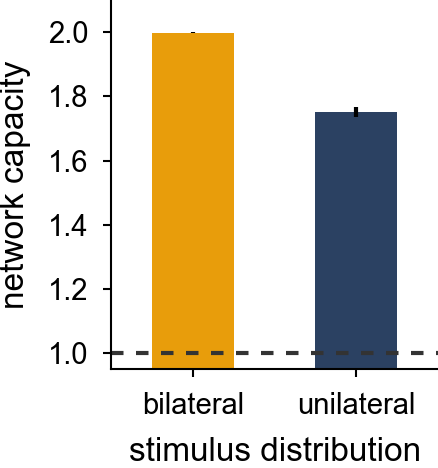

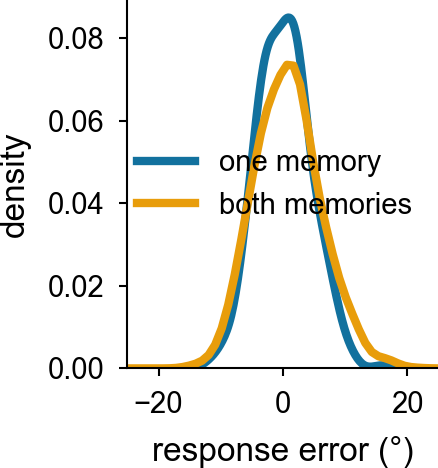

In [8]:
### Capacity comparison
f, ax = plt.subplots(figsize=(1.7, 1.8))
plt.bar(0, np.mean(capacity_across), yerr=sem(capacity_across), color=colors['Across'], width=0.5)
plt.bar(1, np.mean(capacity_within), yerr=sem(capacity_within), color=colors['Within'], width=0.5)
plt.axhline(1, color='#333333', dashes=[3,3])
plt.xlabel('stimulus distribution')
plt.ylabel('network capacity')
sns.despine()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xticks([0,1], ['bilateral', 'unilateral'])
plt.xlim(-0.5,1.5)
plt.ylim(0.95,2.1)
plt.tight_layout()
#plt.savefig('./Figures/Figure6/MultiitemCapacityWithinAcrossSingle.svg', dpi=300)

### Precision comparison when both items are remembered

# get trials where both items stored are the same (strong for one area, weak for other)
oneIdxA = np.where(df_within.strengthA > 2.5)[0]
oneIdxB = np.where(df_within.strengthB > 2.5)[0]
oneErr = np.append(df_within.loc[oneIdxA].errorA, df_within.loc[oneIdxB].errorB)

# each hemisphere represents one item (ACROSS condition)
#df_within_both = df_within[(capacity_within==2)].copy()
twoErr = np.append(df_across.errorA, df_across.errorB)

df_within_both = df_within[(capacity_within==2)].copy()
df_within_one = df_within[(capacity_within==1) & (df_within.errorA < correct_cut)].copy()
f, ax = plt.subplots(figsize=(1.7, 1.8))
sns.kdeplot(np.rad2deg(oneErr), color=colors['Reactivation'],\
         label='one memory', lw=2)#, edgecolor=colors['Reactivation'], bins=np.linspace(-20, 20, 31)
sns.kdeplot(np.rad2deg(twoErr), color=colors['Across'],\
         label='both memories', lw=2)
plt.xlabel('response error (°)')
plt.ylabel('density')
plt.legend()
sns.despine()
plt.xlim([-25, 25])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
#plt.savefig('./Figures/Figure6/OneVsTwoItemPrecision.svg', dpi=300)
print("STD of one memory: "+str(np.std(np.rad2deg(oneErr)))+'\n'+\
    'STD of both memories:'+str(np.std(np.rad2deg(twoErr))))

### Compare precsion

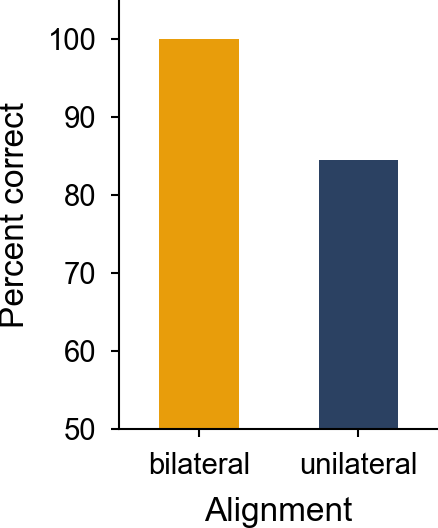

In [9]:
f, ax = plt.subplots(figsize=(1.7, 2.))
plt.bar(0, perc_across, color=colors['Across'], width=0.5)
plt.bar(1, perc_within, color=colors['Within'], width=0.5)
plt.xlabel('Alignment')
plt.ylabel('Percent correct')
sns.despine()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xticks([0,1], ['bilateral', 'unilateral'])
plt.xlim(-0.5,1.5)
plt.ylim(50,105)
plt.tight_layout()
#plt.savefig('./Figures/Figure6/MultiitemPrecisionWithinAcross.svg', dpi=300)
